In [345]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')
sys.path.insert(0, './archive')

import experiment as exp
import plot
import predict

import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from hdf5storage import loadmat

import os
import math
import torch
import torchaudio
import pytorch_lightning as pl

import dynamic_strf.modeling as modeling
import dynamic_strf.estimate as estimate
import dynamic_strf.visualize as visualize

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [346]:
e = exp.load('is_multiexp_test02', experiment_location='experiments', datadir='Mdata')
e.trials.where(e.trials.name == 'cnim_scaffold2')

,null_adjusted_LL,num_filters,num_inh_percent,expt,kernel_widths,kernel_heights,copy_weights,freeze_weights,include_MUs,is_multiexp,modelstr,d2xt,l1,center,bcs,name,trial,mean_LLs
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,True,"32,16,8",0.75,expt04+expt05+expt06+expt07,"21,21,21","3,3,3",False,False,False,True,cnim_scaffold,0.01,0.0001,0.01,{'d2xt': 1},cnim_scaffold2,<experiment.Trial object at 0x7f2c770cdf40>,0.285043
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [347]:
model = e.trials_where(name='cnim_scaffold2')[0].model
dataset = e.trials_where(name='cnim_scaffold2')[0].dataset

lazy loading dataset
Loading expt04
  Time embedding...
  Done.
Loading expt05
  Time embedding...
  Done.
Loading expt06
  Time embedding...
  Done.
Loading expt07
  Time embedding...
  Done.


In [348]:
dataset[0]

{'stim': tensor([ 0.,  1., -1., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
          1., -1.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  1.,  0.,  0.,  1.,  0.,
         -1.,  1.,  0., -1.,  1.,  0., -1.,  1.,  0., -1., -1., -1.,  0.,  0.,
          1.,  0.,  1.,  1.,  0., -1., -1.,  0.,  0.,  1.,  1.,  0.,  1., -1.,
          0.,  0., -1.,  1.,  0.,  1.,  0., -1.,  1.,  1.,  1.,  1.,  0.,  0.,
          0.,  1.,  1.,  1.,  0.,  1., -1.,  0.,  1.,  0.,  0.,  1., -1.,  1.,
          0.,  0.,  1.,  0.,  0., -1.,  0.,  1., -1.,  0.,  1.,  0.,  0.,  1.,
          0.,  1.,  0., -1.,  0.,  1.,  0., -1.,  0.,  1.,  0.,  0.,  0., -1.,
         -1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          1., -1.,  1.,  0.,  0.,  0.,  0., -1., -1.,  1., -1.,  1.,  0., -1.,
          0., -1.,  0.,  1.,  0.,  0.,  1., -1.,  0., -1.,  0.,  1.,  1.,  0.,
          0.,  1.,  1.,  0., -1.,  1.,  0., -1.,  1.,  1.,  1.,  0., -1., -1.,
          1.,  0.,  0.,  0.,  1., -1., -1., 

In [6]:
@torch.no_grad()
def dSTRF(model, x, chunk_size=1000, context_size=1000, verbose=0):
    """
    Estimate dynamic spectrotemporal receptive field (dSTRF) of a model for given input `x`.

    Arguments:
        mode: a pytorch model being analyzed. It should accept input of shape [time * in_channels]
            and return output of shape [time * out_channels].
        x: input of shape [time * in_channels].
        chunk_size: number of time samples to calculate dSTRF on simultaneously.
        context_size: length of dataset to use for calculating dSTRF.
        verbose: a boolean, indicating whether to print out progress status.
    
    Returns:
        dstrfs: a dSTRF tensor of shape [time * out_channels * time_lag * in_channels].
    """
    # Pad input such that output has same shape and is half-precision
    
    #x = torch.nn.functional.pad(x, (0, 0, context_size, 0)).half()
    def model_fx(x):
        with torch.cuda.amp.autocast():
            return model.NDN(x)[context_size:]

    dstrfs = []
    chunks = math.ceil((len(x) - context_size) / chunk_size)
    chunks = range(chunks)
    for chunk_idx in chunks:
        chunk_start = chunk_idx * chunk_size
        chunk_length = min(chunk_size + context_size, len(x) - chunk_start)

        # Jacobian has shape [time * channel * lag * frequency]
        jacobian = torch.autograd.functional.jacobian(
            model_fx, x[chunk_start:chunk_start+chunk_length]
        ).cpu()

        dstrfs.append( # dSTRF is of shape [time * channel * lag * frequency]
            torch.stack([j[:, t:t+context_size+1] for t, j in enumerate(jacobian)], dim=0)
        )
        del jacobian

    return torch.cat(dstrfs, dim=0) # shape [time * channel * lag * frequency]

In [7]:
dSTRF(model, dataset, context_size=1000)

TypeError: The inputs given to jacobian must be either a Tensor or a tuple of Tensors but the given inputs has type <class 'dict'>.

In [26]:
inps = dataset.stim
context_size = 1000
def model_fx(x):
    with torch.cuda.amp.autocast():
        return model.NDN.networks[0].layers[0](x)

# Jacobian has shape [time * channel * lag * frequency]
jacobian = torch.autograd.functional.jacobian(
    model_fx, inps[:20], vectorize=True
).cpu()

In [27]:
jacobian.shape

torch.Size([20, 1152, 20, 360])

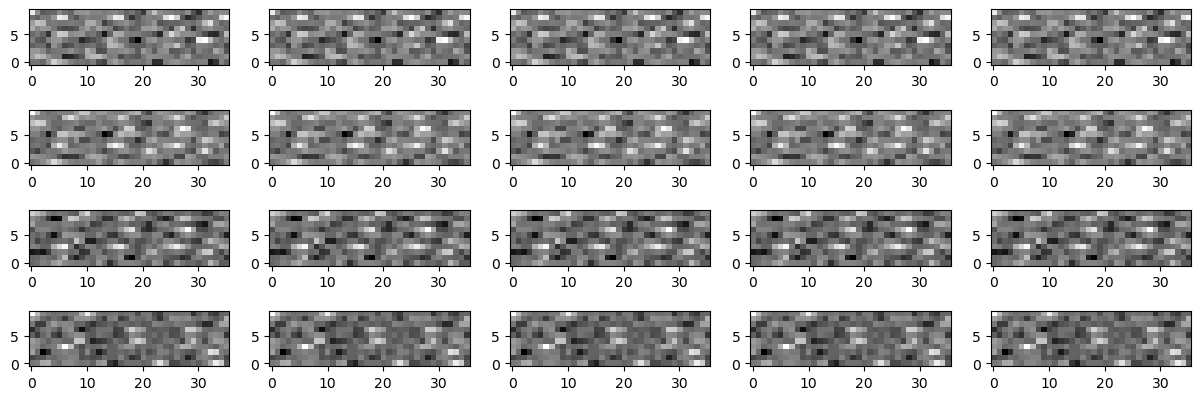

In [29]:
fig = plt.figure(figsize=(15,5))
grid = plt.GridSpec(4, 5)
for i in range(4):
    for j in range(5):
        ax = fig.add_subplot(grid[i,j])
        mean_jacobian = torch.mean(jacobian[i, :, :], axis=0)
        mean_jacobian = torch.mean(mean_jacobian, axis=0)
        imin = torch.min(mean_jacobian.flatten())
        imax = torch.max(mean_jacobian.flatten())
        ax.imshow(mean_jacobian.detach().numpy().reshape(10, 36),
                         vmin=imin, vmax=imax,
                         interpolation='none',
                         cmap='gray',
                         origin='lower')

In [ ]:
# need to install pytorch 1.13 in order to use this
# jacrev = torch.func.jacrev(model.NDN.networks[0].layers[0], inps[0])

In [ ]:
output = model.NDN.networks[0].layers[0](inps[0])

In [ ]:
inps[0].shape, output.shape, jacobian.shape

In [ ]:
fig = plt.plot(jacobian[0, :, :].detach().numpy())

In [ ]:
# separate out excitatory and inhibitory weights
# get num_inh and num_filters from the layer, and separate out when this averaging

# TODO: load the Results object and make a video of the dSTRF for exc and inh over time.

num_filters = model.networks[0].layers[0].params['num_filters']
num_inh = model.networks[0].layers[0].params['num_inh']
num_exc = num_filters - num_inh
num_exc *= 36
num_inh *= 36

dstrf_exc = jacobian[0, :num_exc, :]
dstrf_inh = jacobian[0, num_exc:, :]

mean_exc_weights = torch.mean(jacobian[0, :num_exc, :], axis=0)
mean_inh_weights = torch.mean(jacobian[0, num_exc:, :], axis=0)

In [ ]:
num_exc, num_inh, jacobian.shape

In [ ]:
import matplotlib.pyplot as plt
imin = torch.min(mean_exc_weights.flatten())
imax = torch.max(mean_exc_weights.flatten())
plt.imshow(mean_exc_weights.detach().numpy().reshape(10, 36),
           vmin=imin, vmax=imax,
           interpolation='none',
           cmap='gray',
           origin='lower')

In [ ]:
import matplotlib.pyplot as plt
imin = torch.min(mean_inh_weights.flatten())
imax = torch.max(mean_inh_weights.flatten())
plt.imshow(mean_inh_weights.detach().numpy().reshape(10, 36),
           vmin=imin, vmax=imax,
           interpolation='none',
           cmap='gray',
           origin='lower')

In [ ]:
# from the tutorial
# https://nbviewer.org/github/naplab/DSTRF/blob/master/Examples/Tutorial.ipynb

In [ ]:
# Find maximum value for color axis
vmax = dstrf_exc.abs().max(dim=0)[0].max(dim=0)[0].quantile(0.90)

# Plot figure
plt.figure(figsize=(15, 2))
for i, t in enumerate([100, 200, 300, 400, 500]):
    plt.subplot(1, 5, i+1)
    plt.imshow(
        dstrf_exc[t].detach().numpy().reshape(10, 36), aspect='auto', cmap='gray', vmin=-vmax, vmax=vmax, origin='lower'
    )

    plt.xlabel('Time lag (ms)')
    if i == 0:
        plt.ylabel('Time lag', labelpad=-10)
    else:
        plt.yticks([])
plt.show()

## get the Jacobians through the predict function

In [41]:
model.networks[0].name

'core'

In [122]:
results = predict.predict(model, dataset=dataset[100:300], network_names_to_use=['core'])

In [123]:
results.jacobians[199]['core'][0].shape

torch.Size([1, 1152, 360])

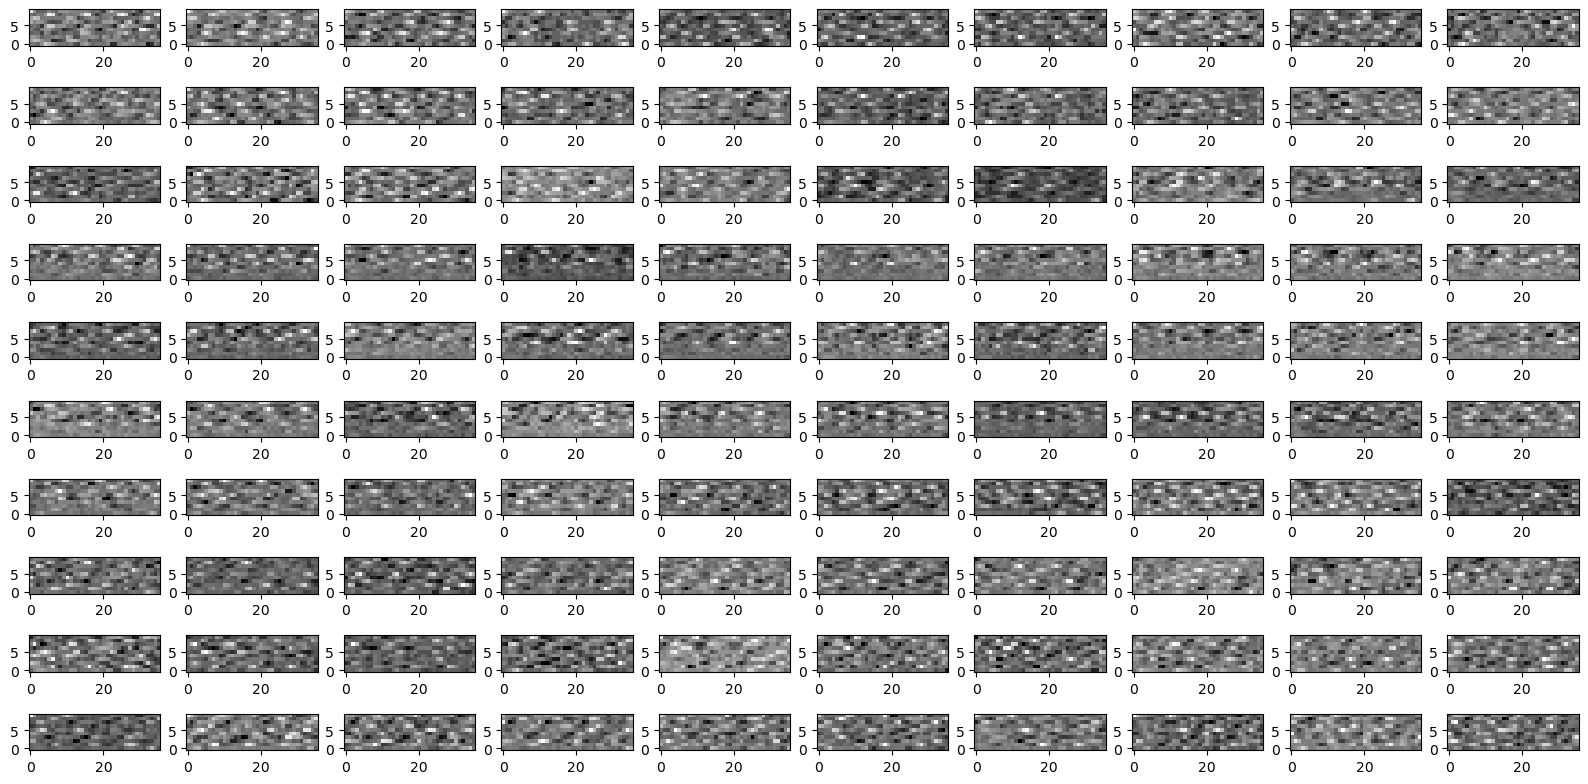

In [63]:
rows = 10
cols = 10
fig = plt.figure(figsize=(20,10))
grid = plt.GridSpec(rows, cols)
k = 0
for i in range(rows):
    for j in range(cols):
        jacobian = results.jacobians[k]['core'][0]
        ax = fig.add_subplot(grid[i,j])
        mean_jacobian = torch.mean(jacobian[0,:,:], axis=0)
        imin = torch.min(mean_jacobian.flatten())
        imax = torch.max(mean_jacobian.flatten())
        ax.imshow(mean_jacobian.detach().numpy().reshape(10, 36),
                  vmin=imin, vmax=imax,
                  interpolation='none',
                  cmap='gray',
                  origin='lower')
        k += 1

# results

In [349]:
start = 50
end = 550
results = predict.predict(model,
                          dataset=dataset[start-50:end+50],
                          network_names_to_use=['core'])

KeyboardInterrupt: 

In [151]:
for i in range(start, end):
    # for time 0 and layer 0 of the core network
    # get the stims
    stim = dataset[i]['stim'][0,:]
    
    # get the Jacobians for the different layers of the core network
    dstrf_excs = []
    dstrf_inhs = []
    for li in range(len(model.networks[0].layers)):
        # get the Jacobians for the inhibitory and excitatory weights
        num_filters = model.networks[0].layers[li].params['num_filters']
        num_inh = model.networks[0].layers[li].params['num_inh']
        num_exc = num_filters - num_inh
        num_exc *= 36
        num_inh *= 36
        jacobian = results.jacobians[i]['core'][0]
        dstrf_exc = torch.mean(jacobian[0, :num_exc, :], axis=0)
        dstrf_inh = torch.mean(jacobian[0, num_exc:, :], axis=0)
        dstrf_excs.append(dstrf_exc)
        dstrf_inhs.append(dstrf_inh)
    
    # get the predicted robs for neuron 0
    pred = results.pred[i-50:i+50, 1]
    robs = results.robs[i-50:i+50, 1]
        
    ## make the plot for a single frame including stim, prediction, and dSTRF
    rows = 5
    cols = 2
    fig = plt.figure(figsize=(10,10))
    grid = plt.GridSpec(rows, cols)
    
    ax_stim = fig.add_subplot(grid[0,:])
    ax_stim.imshow(stim.detach().numpy().reshape(36,10).T,
                   interpolation='none',
                   cmap='gray',
                   origin='lower')
    ax_stim.set_title('Stimulus')
    
    # plot the dstrfs for each layer
    for li in range(len(dstrf_excs)):
        # get the min and max values for the color axis
        imin_exc = torch.min(dstrf_excs[li].flatten())
        imax_exc = torch.max(dstrf_excs[li].flatten())
        imin_inh = torch.min(dstrf_inhs[li].flatten())
        imax_inh = torch.max(dstrf_inhs[li].flatten())
        
        ax_dstrf_exc = fig.add_subplot(grid[li+1,0])
        ax_dstrf_exc.imshow(dstrf_excs[li].detach().numpy().reshape(36,10).T,
                  vmin=imin_exc, vmax=imax_exc,
                  interpolation='none',
                  cmap='gray',
                  origin='lower')
        ax_dstrf_exc.set_title('dSTRF Exc Layer {}'.format(li))
        ax_dstrf_inh = fig.add_subplot(grid[li+1,1])
        ax_dstrf_inh.imshow(dstrf_inhs[li].detach().numpy().reshape(36,10).T,
                            vmin=imin_inh, vmax=imax_inh,
                            interpolation='none',
                            cmap='gray',
                            origin='lower')
        ax_dstrf_inh.set_title('dSTRF Inh Layer {}'.format(li))
    
    ax_robs = fig.add_subplot(grid[len(dstrf_excs)+2,:])
    ax_robs.plot(pred, c='r')
    ax_robs.plot(robs.detach().numpy(), c='b')
    ax_robs.axvline(x=50, color='r', linestyle='--')
    ax_robs.legend(['Predicted', 'Actual'], loc='upper right')
    eat = ax_robs.set_title('Predicted Robs')
    
    # ffmpeg requires that the digits start at 0
    plt.savefig(os.path.join('viz/dstrfs', f'frame-{i-50:04d}.png'))
    plt.close(fig)

In [154]:
# this doesn't work because it can't find the file
import ffmpeg
ffmpeg.input(
    f'viz/dstrfs/frame-%04d.png', framerate=10
).output(
    'dstrfs.mp4', r=60, pix_fmt='yuv420p'
).run(
    overwrite_output=True
)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


(None, None)

In [207]:
os.system("ffmpeg -f image2 -r 5/1 -i ./viz/dstrfs/frame-%04d.png -vcodec mpeg4 -y output.mp4")

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


0

# make video for whole model

In [350]:
start2 = 50
end2 = 550
results2 = predict.predict(model,
                           dataset=dataset[start2-50:end2+50],
                           network_names_to_use=['core'])

In [351]:
results2.pred.shape, results2.robs.shape, len(results2.jacobian), results2.jacobian[0].shape

((600, 29), (600, 29), 600, torch.Size([1, 29, 360]))

In [367]:
#results2.jacobian[0].shape
results2.r2

array([-1.0767078e+01,  5.5525208e-01,  4.7702670e-02,  4.1433406e-01,
        5.4704034e-01,  3.3056736e-04,  2.9047614e-01,  7.7827215e-02,
        5.7608390e-01,  2.3183566e-01, -1.0520005e+00, -3.4765442e+01,
       -2.1935318e+01, -3.5536339e+01, -1.1614892e+01, -1.7155638e+01,
       -2.6141336e+01,  2.9972965e-01, -4.4453789e+01, -1.0131394e+02,
       -6.8578812e+01, -1.0985811e+00,  6.6968137e-01,  5.3225136e-01,
        7.9298866e-01, -8.7804611e+01, -4.7335247e+01, -2.2477908e+00,
       -1.4530608e+01], dtype=float32)

In [361]:
neuron = 6
imin = np.min(np.concatenate([results2.jacobian[i][0,neuron,:].flatten() for i in range(start2, end2)]))
imax = np.max(np.concatenate([results2.jacobian[i][0,neuron,:].flatten() for i in range(start2, end2)]))

for i in range(start2, end2):
    stim = dataset[i]['stim'][:]
    
    # get the Jacobians for the entire model
    dstrf = results2.jacobian[i][0,neuron,:]
    
    # get the predicted robs for neuron 0
    pred = results2.pred[i-50:i+50, neuron]
    robs = results2.robs[i-50:i+50, neuron]
    
    ## make the plot for a single frame including stim, prediction, and dSTRF
    rows = 5
    cols = 10
    fig = plt.figure(figsize=(10,10))
    grid = plt.GridSpec(rows, cols)
    
    ax_stim = fig.add_subplot(grid[0,:])
    ax_stim.imshow(stim.detach().numpy().reshape(36,10).T,
                   interpolation='none',
                   cmap='gray',
                   origin='lower')
    ax_stim.set_title('Stimulus')
    
    # plot the dstrf for the NDN model
    ax_dstrf = fig.add_subplot(grid[1,:])
    ax_dstrf.imshow(dstrf.reshape(36,10).T,
              vmin=imin, vmax=imax,
              interpolation='none',
              cmap='gray',
              origin='lower')
    ax_dstrf.set_title('dSTRF')
    
    ax_robs = fig.add_subplot(grid[2,:])
    ax_robs.plot(pred, c='r')
    ax_robs.plot(robs, c='b')
    ax_robs.axvline(x=50, color='r', linestyle='--')
    ax_robs.legend(['Predicted', 'Actual'], loc='upper right')
    eat = ax_robs.set_title('Predicted Robs')
    
    # ffmpeg requires that the digits start at 0
    plt.savefig(os.path.join('viz/dstrf'+str(neuron), f'frame-{i-50:04d}.png'))
    plt.close(fig)

# this doesn't work because it can't find the file
import ffmpeg
ffmpeg.input(
    f'viz/dstrf'+str(neuron)+'/frame-%04d.png', framerate=10
).output(
    'dstrf'+str(neuron)+'.mp4', r=60, pix_fmt='yuv420p'
).run(
    overwrite_output=True
)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


(None, None)

In [248]:
# from
# https://stackoverflow.com/questions/42481203/heatmap-on-top-of-image
def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap

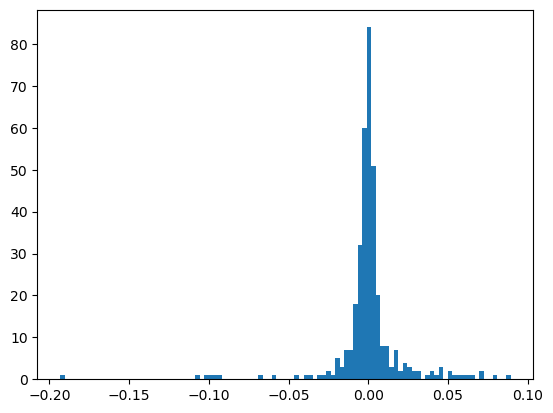

In [284]:
import matplotlib

i = 6
neuron = 1
#imin = np.min(np.concatenate([results2.jacobian[i][0,neuron,:].flatten() for i in range(start2, end2)]))
#imax = np.max(np.concatenate([results2.jacobian[i][0,neuron,:].flatten() for i in range(start2, end2)]))

stim = dataset[i]['stim'][0,:]

# get the Jacobians for the entire model
dstrf = results2.jacobian[i][0,neuron,:]
imin = torch.min(dstrf.flatten())
imax = torch.max(dstrf.flatten())

# get the predicted robs for neuron 0
pred = results2.pred[i-50:i+50, neuron]
robs = results2.robs[i-50:i+50, neuron]

_ = plt.hist(dstrf.flatten().detach().numpy(), bins=100)

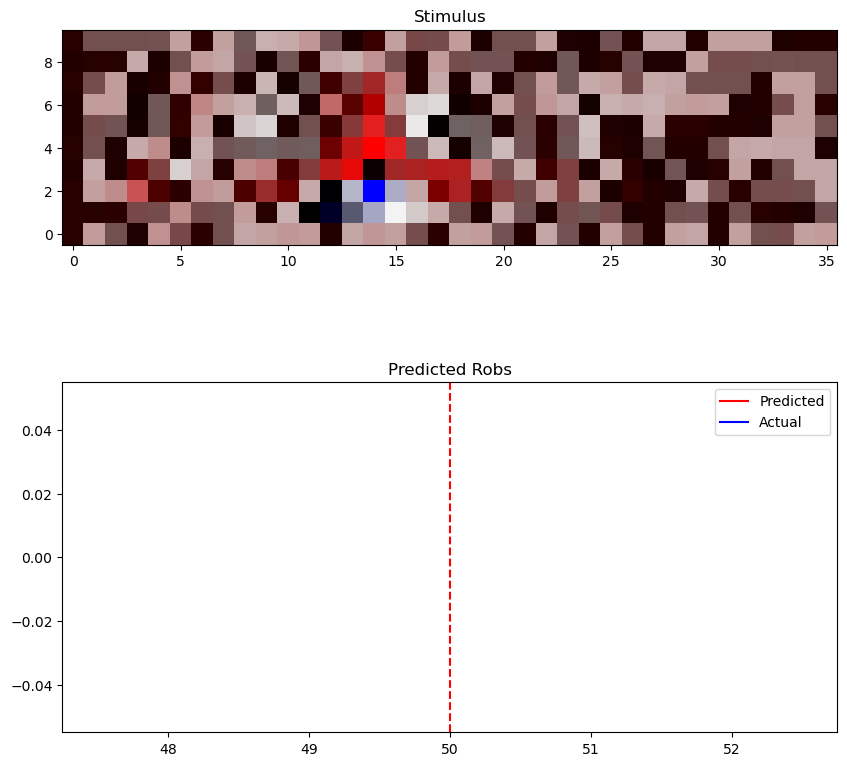

In [285]:
## make the plot for a single frame including stim, prediction, and dSTRF
rows = 2
cols = 1
fig = plt.figure(figsize=(10,10))
grid = plt.GridSpec(rows, cols)

ax_stim = fig.add_subplot(grid[0,:])
ax_stim.imshow(stim.detach().numpy().reshape(36,10).T,
               interpolation='none',
               cmap='gray',
               origin='lower')

c_blue = matplotlib.colors.colorConverter.to_rgba('blue',alpha = 1)
c_white = matplotlib.colors.colorConverter.to_rgba('black',alpha = 0)
c_red= matplotlib.colors.colorConverter.to_rgba('red',alpha = 1)
cmap_bwr = matplotlib.colors.LinearSegmentedColormap.from_list('bwr_cmap', [c_blue, c_white, c_red], 100)
ax_stim.imshow(dstrf.reshape(36,10).T,
                vmin=imin, vmax=imax,
                interpolation='none',
                cmap=cmap_bwr,
                origin='lower')
ax_stim.set_title('Stimulus')

ax_robs = fig.add_subplot(grid[1,:])
ax_robs.plot(pred, c='r')
ax_robs.plot(robs, c='b')
ax_robs.axvline(x=50, color='r', linestyle='--')
ax_robs.legend(['Predicted', 'Actual'], loc='upper right')
_ = ax_robs.set_title('Predicted Robs')

# ffmpeg requires that the digits start at 0
#plt.savefig(os.path.join('viz/dstrf', f'frame-{i-50:04d}.png'))
#plt.close(fig)

# clustering

In [161]:
len(dstrf_excs), len(dstrf_inhs)

(3, 3)

In [184]:
dstrf_excs_L2 = []
dstrf_inhs_L2 = []
stims = []
layer = 2
for i in range(start, end):
    # for time 0 and layer 0 of the core network
    # get the stims
    stim = dataset[i]['stim'][0,:]
    stims.append(stim.numpy())

    # get the Jacobians for the inhibitory and excitatory weights
    num_filters = model.networks[0].layers[layer].params['num_filters']
    num_inh = model.networks[0].layers[layer].params['num_inh']
    num_exc = num_filters - num_inh
    num_exc *= 36
    num_inh *= 36
    jacobian = results.jacobians[i]['core'][0]
    dstrf_exc = torch.mean(jacobian[0, :num_exc, :], axis=0)
    dstrf_inh = torch.mean(jacobian[0, num_exc:, :], axis=0)
    dstrf_excs_L2.append(dstrf_exc.numpy())
    dstrf_inhs_L2.append(dstrf_inh.numpy())

dstrf_excs_L2 = np.array(dstrf_excs_L2)
dstrf_inhs_L2 = np.array(dstrf_inhs_L2)
stims = np.array(stims)

In [185]:
dstrf_excs_L2.shape, dstrf_inhs_L2.shape, stims.shape

((500, 360), (500, 360), (500, 360))

In [189]:
import umap
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
reducer_excs = umap.UMAP()
scaled_R_excs = StandardScaler().fit_transform(dstrf_excs_L2)
dstrf_excs_embedding = reducer_excs.fit_transform(scaled_R_excs)

reducer_inhs = umap.UMAP()
scaled_R_inhs = StandardScaler().fit_transform(dstrf_inhs_L2)
dstrf_inhs_embedding = reducer_inhs.fit_transform(scaled_R_inhs)

reducer_stims = umap.UMAP()
scaled_stims = StandardScaler().fit_transform(stims)
stims_embedding = reducer_stims.fit_transform(scaled_stims)

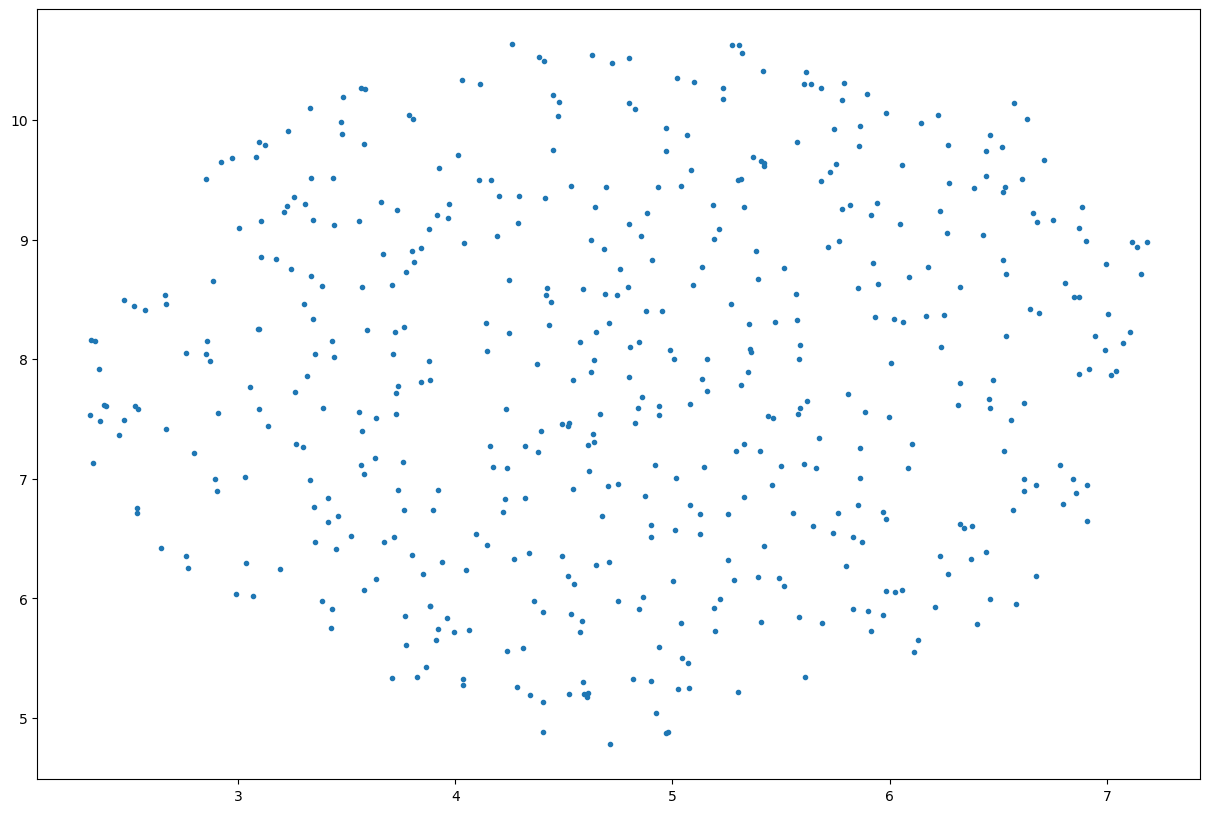

In [194]:
# plot it|
plt.figure(figsize=(15,10))
plt.scatter(dstrf_excs_embedding[:,0], dstrf_excs_embedding[:,1], 
            #c=range(500), cmap='rainbow', 
            marker='.')
plt.show()

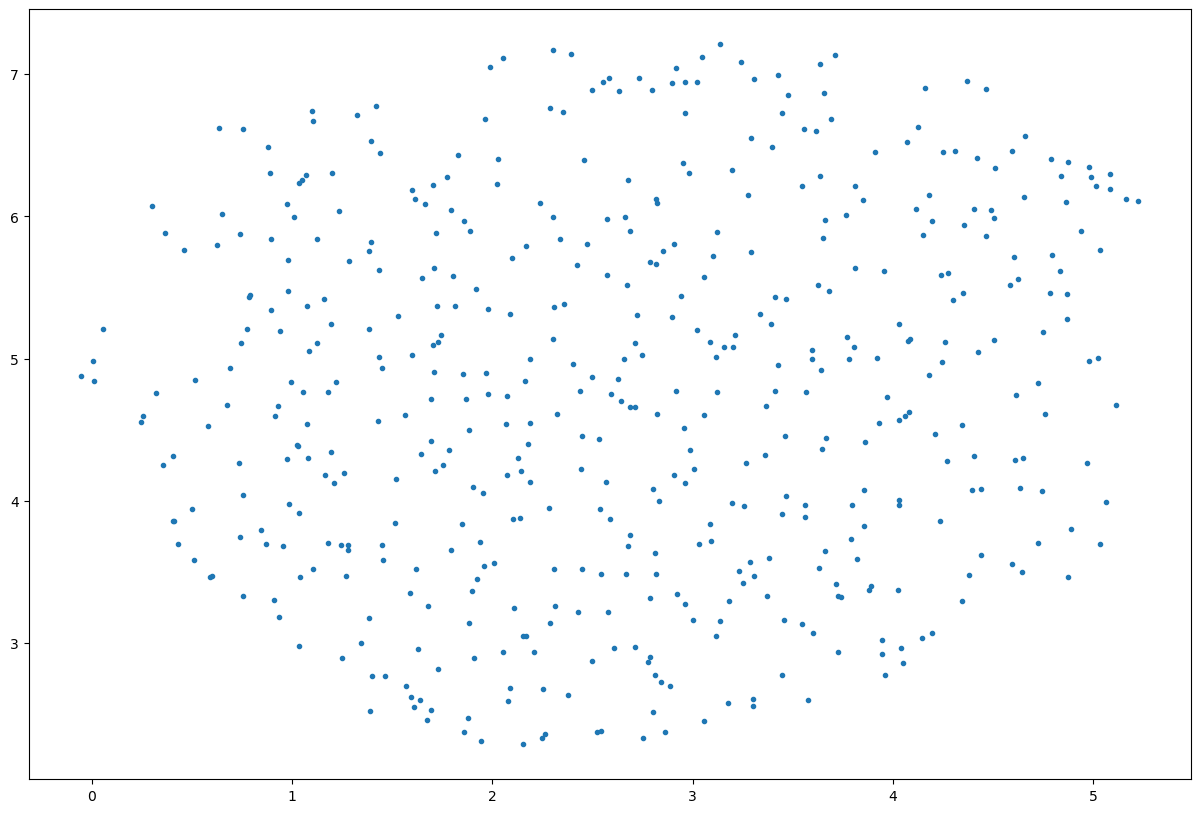

In [195]:
# plot it
plt.figure(figsize=(15,10))
plt.scatter(dstrf_inhs_embedding[:,0], dstrf_inhs_embedding[:,1], 
            #c=range(500), cmap='rainbow', 
            marker='.')
plt.show()

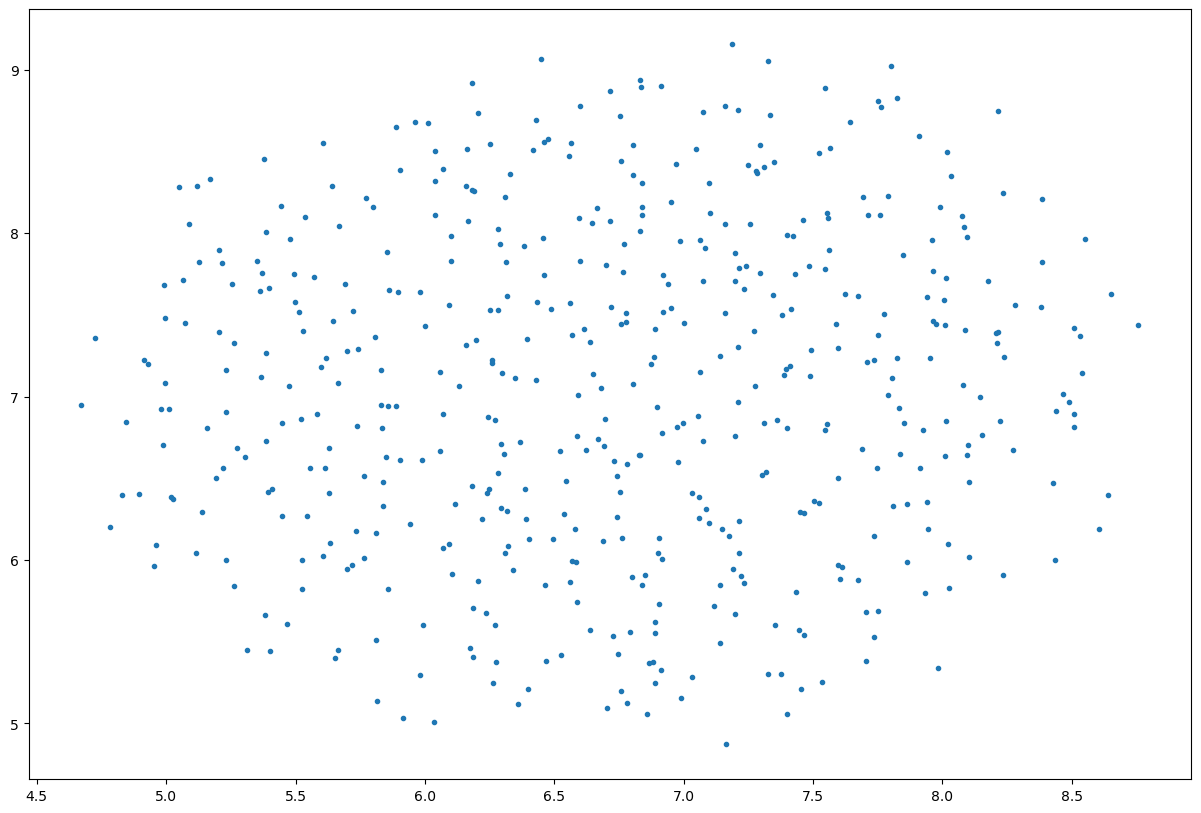

In [193]:
# plot stims
plt.figure(figsize=(15,10))
plt.scatter(stims_embedding[:,0], stims_embedding[:,1], 
            #c=range(500), cmap='rainbow', 
            marker='.')
plt.show()

# clustering for the whole model DSTRF

In [297]:
dstrfs = np.array([jac[0,neuron,:].detach().numpy() for jac in results2.jacobian])

In [299]:
# cluster the dstrfs using UMAP
import umap
reducer = umap.UMAP()
scaled_R = StandardScaler().fit_transform(dstrfs)
embedding = reducer.fit_transform(scaled_R)

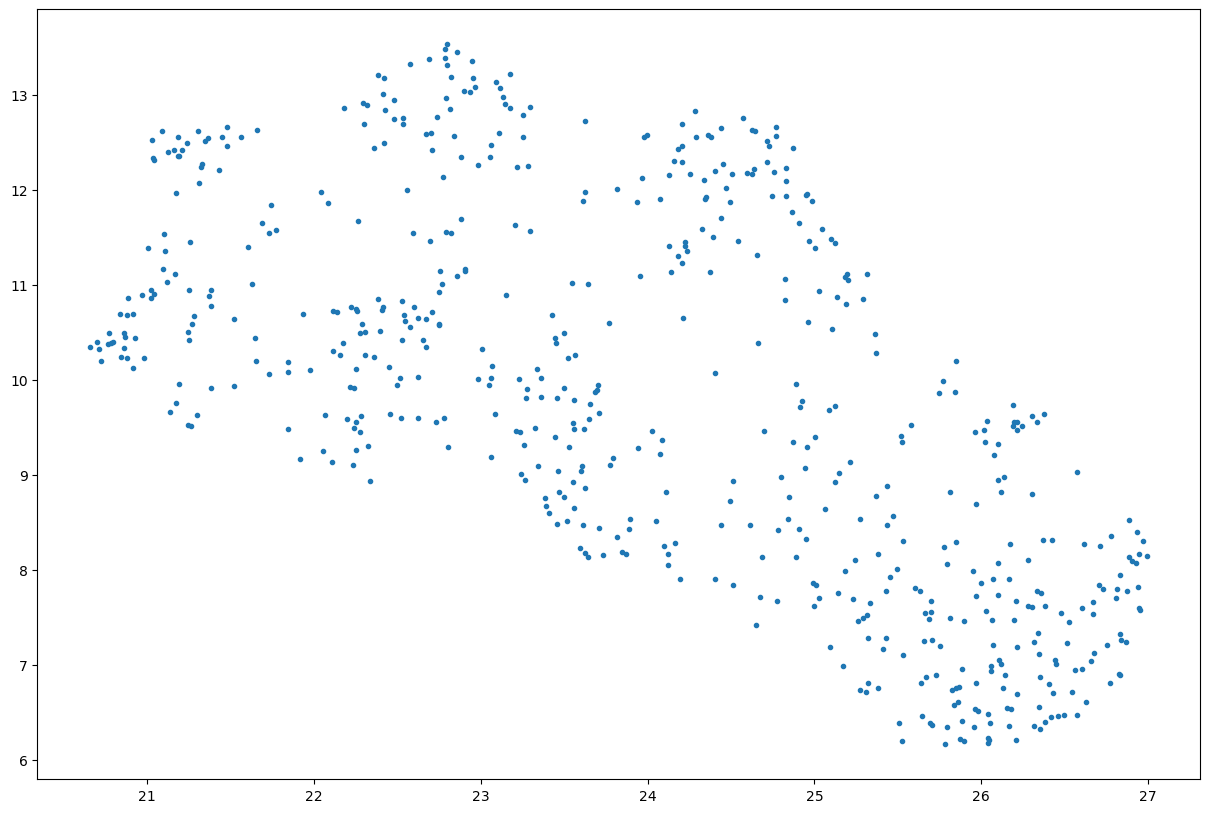

In [303]:
# plot the embedding
plt.figure(figsize=(15,10))
plt.scatter(embedding[:,0], embedding[:,1], marker='.')

In [313]:
import hdbscan
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=10).fit_predict(embedding)
np.unique(hdbscan_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

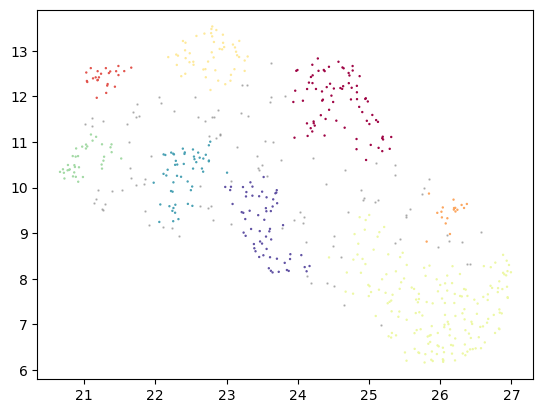

In [318]:
clustered = (hdbscan_labels >= 0)
plt.scatter(embedding[~clustered, 0],
            embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.5,
            alpha=0.5)
plt.scatter(embedding[clustered, 0],
            embedding[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.5,
            cmap='Spectral');

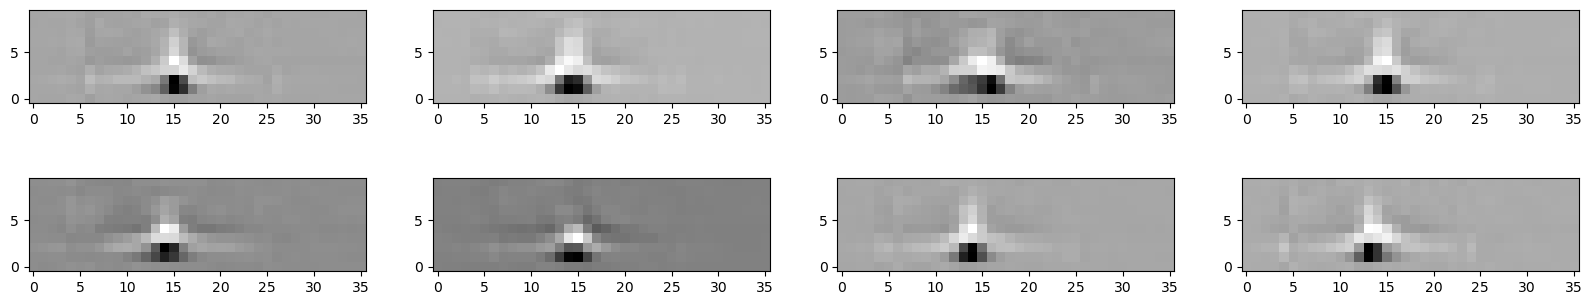

In [343]:
rows = 2
cols = 4
fig = plt.figure(figsize=(20,4))
grid = plt.GridSpec(rows, cols)
for label in range(np.max(hdbscan_labels)+1):
    row, col = np.unravel_index(label, (rows, cols))
    ax_cluster = fig.add_subplot(grid[row, col])
    mean = np.mean(dstrfs[hdbscan_labels == label], axis=0)
    imin = np.min(mean)
    imax = np.max(mean)
    ax_cluster.imshow(np.mean(dstrfs[hdbscan_labels == label], axis=0).reshape(36,10).T,
           vmin=imin, vmax=imax,
           interpolation='none',
           cmap='gray',
       origin='lower')